<a href="https://colab.research.google.com/github/RENISA-GRACELIN/Online_Internship_Projects/blob/main/1_newlayer_SVM_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import os
import numpy as np
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Data directories
train_dir = '/content/drive/MyDrive/A/Train'
test_dir = '/content/drive/MyDrive/A/Test'

Mounted at /content/drive


In [3]:
# Image dimensions
img_width, img_height = 300, 300  # Adjust according to your image dimensions
batch_size = 32
num_epochs = 20

In [4]:
# Load VGG16 model for feature extraction
model = MobileNet(weights='imagenet', include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [5]:
# Function to extract features from an image using EfficientNetB3
def extract_features_Mobilenet(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features

In [6]:
# Load images and extract features
x_train, y_train = [], []
for i in range(5):
    class_dir = os.path.join(test_dir, str(i))
    for img_path in os.listdir(class_dir):
        features = extract_features_Mobilenet(os.path.join(class_dir, img_path))
        x_train.append(features)
        y_train.append(i)

1/1 [==============================] - 0s 80ms/step


In [7]:
# Load images and extract features
x_test, y_test = [], []
for i in range(5):
    class_dir = os.path.join(test_dir, str(i))
    for img_path in os.listdir(class_dir):
        features = extract_features_Mobilenet(os.path.join(class_dir, img_path))
        x_test.append(features)
        y_test.append(i)

1/1 [==============================] - 0s 49ms/step


In [8]:
import torch

# Load the model using torch.load
model_classification = torch.load('/content/drive/MyDrive/NewModel.h5')

# Function to classify features using NewModel.h5
def classify_features(features):
    # Convert features to torch tensor
    features_tensor = torch.tensor(features)

    # Set the model to evaluation mode
    model_classification.eval()

    # Forward pass
    with torch.no_grad():
        predictions = model_classification(features_tensor)

    # Get the predicted classes
    _, predicted_classes = torch.max(predictions, 1)

    return predicted_classes.numpy()

Training SVM with LINEAR kernel...
True Positives: 300
True Negatives: 1200
False Positives: 0
False Negatives: 0
Accuracy: 1.0
Precision: 1.0
Specificity: 1.0
Sensitivity: 1.0
F1 Score: 1.0
Recall: 1.0



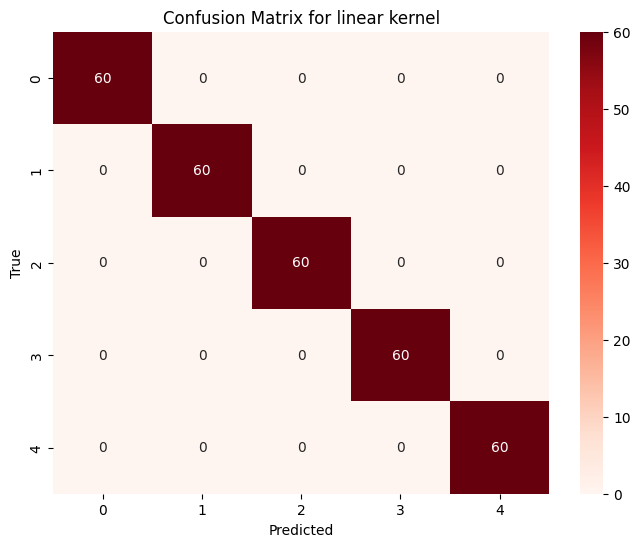

Training SVM with POLY kernel...
True Positives: 294
True Negatives: 1194
False Positives: 6
False Negatives: 6
Accuracy: 0.992
Precision: 0.9805393971443681
Specificity: 0.995
Sensitivity: 0.9800000000000001
F1 Score: 0.9800784882853135
Recall: 0.9800000000000001



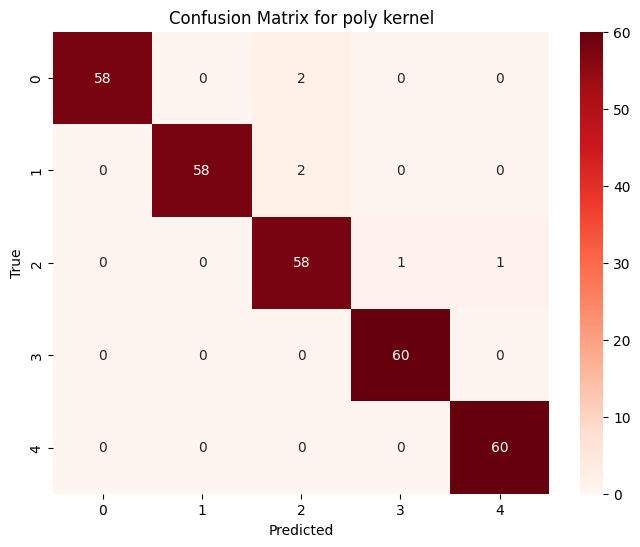

Training SVM with RBF kernel...
True Positives: 260
True Negatives: 1160
False Positives: 40
False Negatives: 40
Accuracy: 0.9466666666666667
Precision: 0.8767233279272297
Specificity: 0.9666666666666667
Sensitivity: 0.8666666666666668
F1 Score: 0.8689880907337404
Recall: 0.8666666666666668



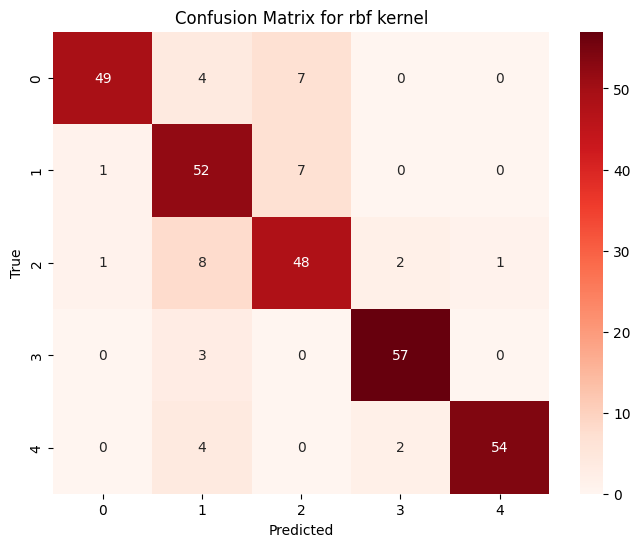

Training SVM with SIGMOID kernel...
True Positives: 197
True Negatives: 1097
False Positives: 103
False Negatives: 103
Accuracy: 0.8626666666666667
Precision: 0.6606666871909643
Specificity: 0.9141666666666667
Sensitivity: 0.6566666666666666
F1 Score: 0.6472927044762895
Recall: 0.6566666666666666



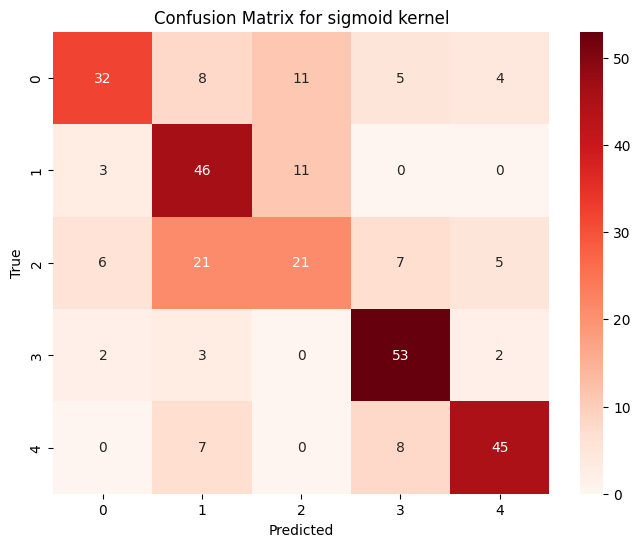

Training SVM with POLYNOMIAL_EXPONENTIAL kernel...
True Positives: 300
True Negatives: 1200
False Positives: 0
False Negatives: 0
Accuracy: 1.0
Precision: 1.0
Specificity: 1.0
Sensitivity: 1.0
F1 Score: 1.0
Recall: 1.0



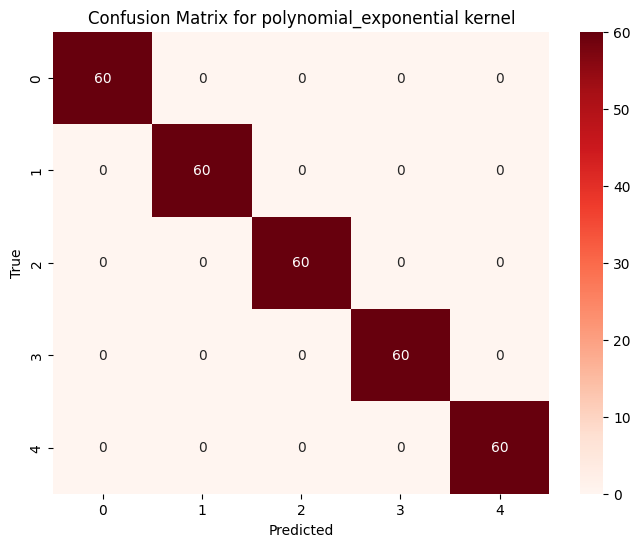

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
import seaborn as sns
from sklearn import svm, metrics

# Flatten the features
x_train_flat = np.array([feature.flatten() for feature in x_train])
x_test_flat = np.array([feature.flatten() for feature in x_test])

# List of kernels to try
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'polynomial_exponential']

for kernel in kernels:
    print(f"\033[1mTraining SVM with {kernel.upper()} kernel...\033[0m")

    # Train SVM classifier
    if kernel == 'polynomial_exponential':
        clf = svm.SVC(kernel='precomputed')
        # Pre-compute the kernel matrix
        gram_train = np.dot(x_train_flat, x_train_flat.T)
        clf.fit(gram_train, y_train)
        gram_test = np.dot(x_test_flat, x_train_flat.T)
    else:
        clf = svm.SVC(kernel=kernel)
        clf.fit(x_train_flat, y_train)

    # Predict on test set
    if kernel == 'polynomial_exponential':
        y_pred = clf.predict(gram_test)
    else:
        y_pred = clf.predict(x_test_flat)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute TP, TN, FP, FN for each class
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    num_classes = cm.shape[0]
    TN = []
    for i in range(num_classes):
        temp = np.delete(cm, i, 0)   # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))

    # Compute overall TP, TN, FP, FN
    overall_TP = np.sum(TP)
    overall_TN = np.sum(TN)
    overall_FP = np.sum(FP)
    overall_FN = np.sum(FN)

    # Compute accuracy, precision, specificity, sensitivity, F1-score, recall
    accuracy = (overall_TP + overall_TN) / (overall_TP + overall_TN + overall_FP + overall_FN)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    specificity = overall_TN / (overall_TN + overall_FP)

    # Print performance metrics
    print(f'True Positives: {overall_TP}')
    print(f'True Negatives: {overall_TN}')
    print(f'False Positives: {overall_FP}')
    print(f'False Negatives: {overall_FN}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Specificity: {specificity}')
    print(f'Sensitivity: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Recall: {recall}\n')

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {kernel} kernel')
    plt.show()


1/1 [==============================] - 1s 864ms/step


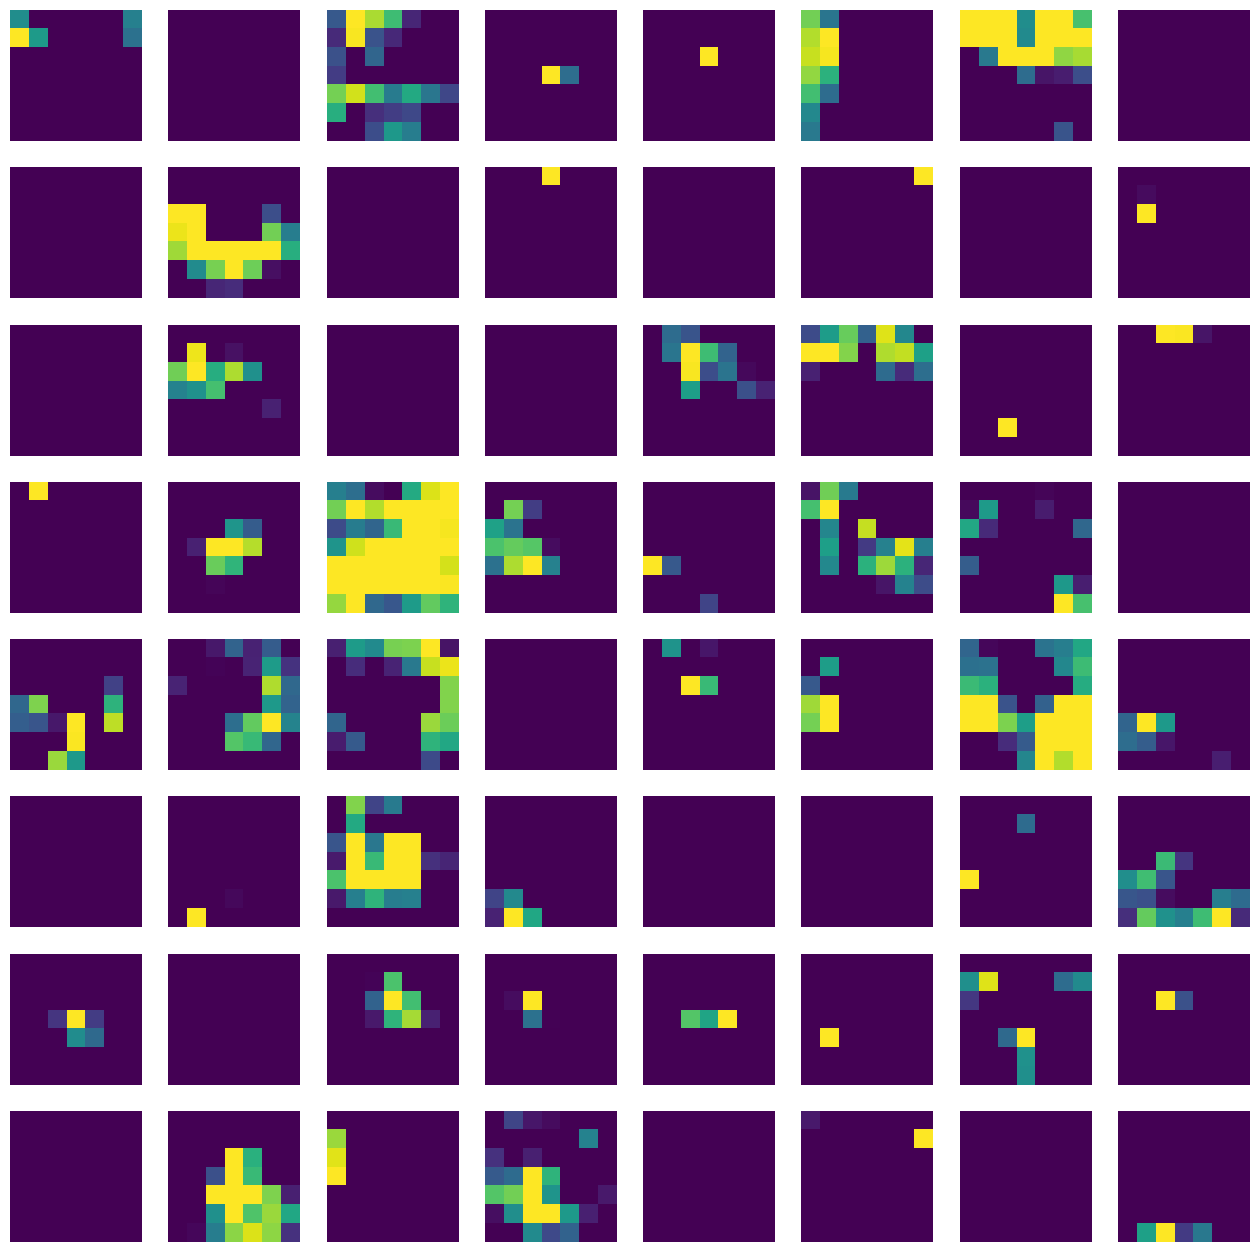

In [14]:
from tensorflow.keras.models import Model
layer_name = 'conv_pw_13_relu'
feature_extractor_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Load and preprocess an example image
img_path = '/content/drive/MyDrive/A/Train/0/10.jpg'  # Change this to your image file path
img = image.load_img(img_path, target_size=(224, 224))  # MobileNetV2 input size
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract features from the example image
features = feature_extractor_model.predict(x)

# Visualize the feature maps
plt.figure(figsize=(16, 16))
num_subplots = min(64, features.shape[-1])  # Limit the number of subplots to 64 or the actual number of features
for i in range(num_subplots):
    plt.subplot(8, 8, i + 1)
    plt.imshow(features[0, :, :, i], cmap='viridis')
    plt.axis('off')

plt.show()